In [255]:
import pandas as pd
import numpy as np
import re
import datetime

In [256]:
df = pd.read_excel("data/ibrx_mensal.xlsx", na_values="-")


In [257]:
# transforming the 'Data' column to a date format
df['Data'] = df['Data'].str.replace('Jan', '01').str.replace('Fev', '02').str.replace('Mar', '03').str.replace('Abr', '04').str.replace('Mai', '05').str.replace('Jun', '06').str.replace('Jul', '07').str.replace('Ago', '08').str.replace('Set', '09').str.replace('Out', '10').str.replace('Nov', '11').str.replace('Dez', '12')
df['Data'] = pd.to_datetime(df['Data'], format='%m-%Y')

In [258]:
df = df[(df['Data'] >= '2000-01-01') & (df['Data'] <= '2020-02-01')]

# replacing NA values with 0
df = df.dropna(axis=1)


In [259]:
df.columns

Index(['Data', 'ALPA4', 'ABEV3', 'BBDC3', 'BBDC4', 'BBAS3', 'BRKM5', 'CMIG4',
       'CPLE6', 'ELET3', 'ELET6', 'EMBR3', 'EGIE3', 'GGBR4', 'GOAU4', 'ITSA4',
       'ITUB4', 'LIGT3', 'PETR3', 'PETR4', 'SBSP3', 'CSNA3', 'VIVT3', 'TIMS3',
       'USIM5', 'VALE3', 'IBOV'],
      dtype='object')

In [260]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, leaves_list


def HRP_Portfolio(df, linkage_method="single", graph=False):
    if linkage_method not in ["single", "complete", "average", "ward"]:
        return "ERROR: linkage_method argument only supports 'single', 'complete', 'average' or 'ward' options"
    if linkage_method == "ward":
        linkage_method = "ward.D2"
    
    # Stage 1: Tree clustering
    corr = df.corr()
    distance = np.sqrt(0.5 * (1 - corr))
    euclidean_distance = squareform(pdist(distance, metric="euclidean"))
    
    # Stage 2: Quasi-Diagonalisation
    clustering = linkage(euclidean_distance, method=linkage_method)
    clusters_order = leaves_list(clustering)
    
    # Stage 3: Recursive Bisection
    weights = np.ones(df.shape[1])
    index = [clusters_order.tolist()]
    while len(index) > 0:
        new_index = []
        for i in index:
            middle = len(i) // 2
            indexa = i[:middle]
            indexb = i[middle:]
            covar_clustera = df.iloc[:, indexa].iloc[indexa, :]
            covar_clusterb = df.iloc[:, indexb].iloc[indexb, :]
            weightsa = 1 / np.diag(covar_clustera)
            weightsa /= np.sum(weightsa)
            weightsb = 1 / np.diag(covar_clusterb)
            weightsb /= np.sum(weightsb)
            variance_clustera = np.dot(weightsa, np.dot(covar_clustera, weightsa))
            variance_clusterb = np.dot(weightsb, np.dot(covar_clusterb, weightsb))
            alpha = 1 - variance_clustera / (variance_clustera + variance_clusterb)
            weights[indexa] *= alpha
            weights[indexb] *= (1 - alpha)
            if len(indexa) > 1:
                new_index.append(indexa)
            if len(indexb) > 1:
                new_index.append(indexb)
        index = new_index
    
    if graph:
        import matplotlib.pyplot as plt
        from scipy.cluster.hierarchy import dendrogram
        
        plt.figure(figsize=(10, 7))
        plt.xlabel("Stocks")
        plt.ylabel("Distance")
        plt.title("Cluster Dendrogram - HRP")
        column_names = list(df.columns)
        dendrogram(clustering, leaf_rotation=90, leaf_font_size=8, labels=column_names)
        plt.show()


    
    return weights


In [261]:
import pandas as pd
import numpy as np

def min_var_portfolio(cov):
    inv_cov = np.linalg.inv(cov)
    ones = np.ones(len(cov))
    return np.dot(inv_cov, ones) / np.dot(np.dot(ones, inv_cov), ones)


def rolling_window_HRP(data, window_size):
    
    """
    This function applies the Hierarchical Risk Parity algorithm to a rolling window of historical returns.

    Parameters:
    data (DataFrame): Historical returns with dates in a column.
    window_size (int): The size of the rolling window.

    Returns:
    DataFrame: A dataframe with the realized returns, HRP returns and MV returns for each out-of-sample window.
    """

    number_of_rows = len(data)
    number_of_columns = len(data.columns)
    weights = np.zeros((number_of_rows - 1, number_of_columns - 1))
    weights_mv = np.zeros((number_of_rows - 1, number_of_columns - 1))
    out_of_sample = number_of_rows - window_size
    Rport = np.empty((out_of_sample, 4))
    
    for i in range(out_of_sample):
        df_rolling = data.iloc[i:i + window_size, 1:]
        df_cov = pd.DataFrame(df_rolling.cov().values, columns=df_rolling.columns, index=df_rolling.columns)
        weights[i, :] = HRP_Portfolio(df_cov, graph=False)
        weights_mv[i, :] = min_var_portfolio(df_cov)
        Rport[i, 0] = data.iloc[i + window_size, 0]  
        Rport[i, 1] = np.mean(data.iloc[i + window_size, 1:])
        Rport[i, 2] = np.dot(weights[i, :], data.iloc[i + window_size, 1:])
        Rport[i, 3] = np.dot(weights_mv[i, :], data.iloc[i + window_size, 1:])
    
    Rport = pd.DataFrame(Rport, columns=["Date", "Equal Weights", "HRP", "MV"])
    Rport["Date"] = pd.to_datetime(Rport["Date"])
    
    return Rport


C:\Users\felip\AppData\Local\Temp\ipykernel_14620\3867758454.py:19: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  clustering = linkage(euclidean_distance, method=linkage_method)


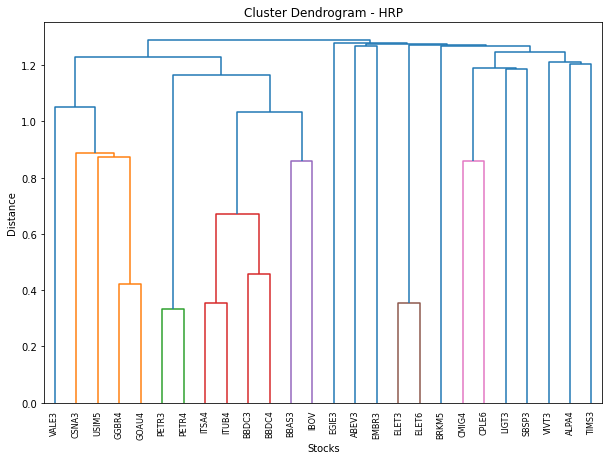

array([ 2.08638056e-02, -2.91264678e-01, -4.47885337e-02,  5.47972803e-02,
        1.06024938e-01, -1.29596427e-02,  9.43759797e-02,  3.82186502e-01,
       -3.77468100e-01,  1.60779034e-02, -3.15955950e-01,  6.40846572e-01,
        4.76923767e-02,  4.27274969e-01,  8.49221312e-03, -5.41842961e-03,
       -5.25713692e-02,  3.28173235e-01, -5.90883970e-02, -3.42546640e-03,
       -4.09921033e-04, -4.22808940e-04, -6.09413539e-03,  6.95227688e-04,
        9.37666974e-02, -5.14002679e-02])

In [264]:
df2 = df.iloc[:, 1:]
hrp = HRP_Portfolio(df2, graph=True)
hrp

In [267]:
rolling_window_HRP(df2, 60)

C:\Users\felip\AppData\Local\Temp\ipykernel_14620\3867758454.py:19: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  clustering = linkage(euclidean_distance, method=linkage_method)


,Date,Equal Weights,HRP,MV
0,1970-01-01 00:00:00.000000000,-5.999268,-4.994623,-8.396179
1,1970-01-01 00:00:00.000000002,15.019031,13.874689,14.817926
2,1969-12-31 23:59:59.999999993,-6.380284,-7.403602,-5.429452
3,1969-12-31 23:59:59.999999992,-6.549963,-9.712360,-19.441430
4,1970-01-01 00:00:00.000000007,3.881629,2.924667,4.257075
...,...,...,...,...
177,1970-01-01 00:00:00.000000005,1.006296,-0.991657,-3.551084
178,1970-01-01 00:00:00.000000016,3.352928,3.715713,3.305966
179,1970-01-01 00:00:00.000000004,9.734312,8.935761,5.657007
180,1970-01-01 00:00:00.000000007,-1.348356,-0.539980,5.627517


In [271]:
rolling_window_HRP(df2, 60)

C:\Users\felip\AppData\Local\Temp\ipykernel_14620\3867758454.py:19: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  clustering = linkage(euclidean_distance, method=linkage_method)


,Date,Equal Weights,HRP,MV
0,1970-01-01 00:00:00.000000000,-5.999268,-4.994623,-8.396179
1,1970-01-01 00:00:00.000000002,15.019031,13.874689,14.817926
2,1969-12-31 23:59:59.999999993,-6.380284,-7.403602,-5.429452
3,1969-12-31 23:59:59.999999992,-6.549963,-9.712360,-19.441430
4,1970-01-01 00:00:00.000000007,3.881629,2.924667,4.257075
...,...,...,...,...
177,1970-01-01 00:00:00.000000005,1.006296,-0.991657,-3.551084
178,1970-01-01 00:00:00.000000016,3.352928,3.715713,3.305966
179,1970-01-01 00:00:00.000000004,9.734312,8.935761,5.657007
180,1970-01-01 00:00:00.000000007,-1.348356,-0.539980,5.627517
